# Divorce Contagion Model using AgentPy

An agent-based model that simulates the propagation of divorce through a network.

In [1]:
# Import libraries.

# Data preprocessing.
import pandas as pd
from scipy import interpolate
import statsmodels.api as sm
from sklearn.impute import KNNImputer

# Model design.
import agentpy as ap
import networkx as nx
import numpy as np

# Visualization.
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

Get useful numerical values from Pairfam dataset.

In [866]:
# Load data from CSV.
apf_1 = pd.read_csv("../data/processed/div_anchor_1.csv")
apf_2 = pd.read_csv("../data/processed/div_anchor_2.csv")
apf_3 = pd.read_csv("../data/processed/div_anchor_3.csv")
apf_4 = pd.read_csv("../data/processed/div_anchor_4.csv")
apf_5 = pd.read_csv("../data/processed/div_anchor_5.csv")
apf_6 = pd.read_csv("../data/processed/div_anchor_6.csv")
apf_7 = pd.read_csv("../data/processed/div_anchor_7.csv")
apf_8 = pd.read_csv("../data/processed/div_anchor_8.csv")

ppf_1 = pd.read_csv("../data/processed/div_partner_1.csv")
ppf_2 = pd.read_csv("../data/processed/div_partner_2.csv")
ppf_3 = pd.read_csv("../data/processed/div_partner_3.csv")
ppf_4 = pd.read_csv("../data/processed/div_partner_4.csv")
ppf_5 = pd.read_csv("../data/processed/div_partner_5.csv")
ppf_6 = pd.read_csv("../data/processed/div_partner_6.csv")
ppf_7 = pd.read_csv("../data/processed/div_partner_7.csv")
ppf_8 = pd.read_csv("../data/processed/div_partner_8.csv")

In [881]:
# Useful functions.
def convert_to_float(df, nan = None):
    """ Convert strings to integers. """

    # Change all values to strings.
    df = df.astype(str)

    # Get the first character in the string (the numerical value of the response).

    for column in df.columns:
    
        df[column] = df[column].apply(lambda x: x.split()[0])

    # Replace nan with NaN.
    if nan == 7:
        df = df.replace({"7": np.nan, "n": np.nan})
    
    else:
        df = df.replace({"n": np.nan})

    # Convert columns to float.
    df = df.astype("float")

    return df


def convert_long_float(df):
    """ Convert years of education to float. """

    def try_except_float(x):
        try:
            x = float(x)
        except:
            x = x.split()[0]
            x = float(x)

        return x
    
    for column in df.columns:
    
        df[column] = df[column].apply(lambda x: try_except_float(x)).values

    return df


def scale_items_5(df):
    """ Scale questions with 5 items scale. """

    # Convert columns to int.
    df = convert_to_float(df, nan = 7)

    # Normalize values.
    df = df.apply(lambda x: (x - 1.0) / 4.0)

    return df


def scale_items_10(df):
    """ Scale questions with 10 items scale. """

    # Convert columns to int.
    df = convert_to_float(df)

    # Normalize values.
    df = df.apply(lambda x: (x) / 10.0)

    return df


def scale_items_7(df):
    """ Scale questions with 7 items scale. """

    # Convert columns to int.
    df = convert_to_float(df)

    # Normalize values.
    df = df.apply(lambda x: (x - 1.0) / 6.0)

    return df


def reverse_item(df):
    """ Reverse items after normalization. """

    # Reverse values from [0, 1] to [1, 0].
    df = df.apply(lambda x: 1 - x)

    return df


def create_tradmarr(df, p = False):
    
    # Transform variables to integer.
    if p:
        cols = [
            "pval1i7", # Marriage is a lifelong union which should not be broken.
            "pval1i2", # You should get married if you permanently live with your partner.
            "pval1i8" # Couples should marry at the latest after a child is born.
        ]
    else:
        cols = [
            "val1i7", # Marriage is a lifelong union which should not be broken.
            "val1i2", # You should get married if you permanently live with your partner.
            "val1i8" # Couples should marry at the latest after a child is born.
        ]


    df[cols] = scale_items_5(df[cols])

    # Value of Children.
    tradmarr = df[cols].mean(axis = 1)

    df["tradmarr"] = tradmarr.apply(lambda x: round(x, 2))

    return df


def create_value_partnership(df, p = False):

    # Transform variables to integer.
    if p:
        cols_1 = [
            "pbce1i1", # Stimulation: Participate in activities with a partner.
            "pbce1i5", # Affect: Receive affection and have a feeling of security in a relationship.
            "pbce1i3", # Status: Achieve social status by having a partner.
            "pbce1i2", # Comfort: Get support from a partner if you need help or are ill.
            "pbce1i4", # Comfort: Have financial advantages in a relationship.
        ]

        cols_2 = [
            "pbce1i8", # Stimulation: Become bored, increasingly familiar in a relationship.
            "pbce1i9", # Status: Have family or friends that don’t accept a partner.
            "pbce1i7", # Comfort: Experience stress related to a relationship.
            "pbce1i10", # Autonomy: Have a partner that will limit you.
        ]

    else:
        cols_1 = [
            "bce1i1", # Stimulation: Participate in activities with a partner.
            "bce1i5", # Affect: Receive affection and have a feeling of security in a relationship.
            "bce1i3", # Status: Achieve social status by having a partner.
            "bce1i2", # Comfort: Get support from a partner if you need help or are ill.
            "bce1i4", # Comfort: Have financial advantages in a relationship.
        ]

        cols_2 = [
            "bce1i8", # Stimulation: Become bored, increasingly familiar in a relationship.
            "bce1i9", # Status: Have family or friends that don’t accept a partner.
            "bce1i7", # Comfort: Experience stress related to a relationship.
            "bce1i10", # Autonomy: Have a partner that will limit you.
        ]

    df[cols_1 + cols_2] = scale_items_5(df[cols_1 + cols_2])

    # Social pressure (p).
    partnership_positive = df[cols_1].mean(axis = 1)

    partnership_negative = df[cols_2].mean(axis = 1)

    df["value_partnership"] = (partnership_positive - partnership_negative).apply(lambda x: round(x, 2))

    return df


def create_quality_partnership(df, p = False):
    
    # Transform variables to integer.
    if p:
        cols_1 = [
            # Intimacy.
            "ppa17i1", # How often do you tell your partner what you’re thinking?
            "ppa17i8", # How often do you share your secrets and private feelings with your partner?

            # Admiration.
            "ppa17i2", # How often does your partner express recognition for what you’ve done?
            "ppa17i5", # How often does your partner show that he/she appreciates you?
        ]

        cols_2 = [
            # Dominance.
            "ppa17i7", # How often does your partner get his/her way when you can’t agree on something? 
            "ppa17i3", # How often does your partner make you do things his/her way?

            # Conflict.
            "ppa17i6", # How often do you and your partner disagree and quarrel?
            "ppa17i4", # How often are you and your partner annoyed or angry with each other?
        ]
    
    else: 
        cols_1 = [
            # Intimacy.
            "pa17i1", # How often do you tell your partner what you’re thinking?
            "pa17i8", # How often do you share your secrets and private feelings with your partner?

            # Admiration.
            "pa17i2", # How often does your partner express recognition for what you’ve done?
            "pa17i5", # How often does your partner show that he/she appreciates you?
        ]

        cols_2 = [
            # Dominance.
            "pa17i7", # How often does your partner get his/her way when you can’t agree on something? 
            "pa17i3", # How often does your partner make you do things his/her way?

            # Conflict.
            "pa17i6", # How often do you and your partner disagree and quarrel?
            "pa17i4", # How often are you and your partner annoyed or angry with each other?
        ]

    df[cols_1 + cols_2] = scale_items_5(df[cols_1 + cols_2])

    # Social pressure (p).
    partnership_positive = df[cols_1].mean(axis = 1)

    partnership_negative = df[cols_2].mean(axis = 1)

    df["quality_partnership"] = (partnership_positive - partnership_negative).apply(lambda x: round(x, 2))

    return df


def create_satisfaction_partnership(df, p = False):
    
    # Transform variables to integer.
    if p:
        cols = [
            "psat3", # All in all, how satisfied are you with your relationship?
            "psat4", # What do you think: how satisfied is your partner with your relationship?
            "psat5" # How satisfied are you with your sex life?
        ]
                
    else:
        cols = [
            "sat3", # All in all, how satisfied are you with your relationship?
            "sat4", # What do you think: how satisfied is your partner with your relationship?
            "sat5" # How satisfied are you with your sex life?
        ]

    df[cols] = scale_items_10(df[cols])

    if p:
        df["sat"] = df["psat3"]
        df["sat_partner"] = df["psat4"]
        df["sat_sex"] = df["psat5"]

    else:
        df["sat"] = df["sat3"]
        df["sat_partner"] = df["sat4"]
        df["sat_sex"] = df["sat5"]

    # Satisfaction with partnership.
    satisfaction = df[cols].mean(axis = 1)

    df["satisfaction_partnership"] = satisfaction.apply(lambda x: round(x, 2))

    return df


def create_personality(df, p = False):

    # Transform variables to integer.
    if p:
        cols_1 = [
        ]

        cols_2 = [
            "pper1i3", # I become angry very quickly.
            "pper1i8", # I work myself up into a quarrel easily.
            "pper1i11", # When others irritate me, I get angry quickly.
        ]
    else:
        cols_1 = [
        ]

        cols_2 = [
            "per1i3", # I become angry very quickly.
            "per1i8", # I work myself up into a quarrel easily.
            "per1i11", # When others irritate me, I get angry quickly.
        ]

    df[cols_1] = reverse_item(scale_items_5(df[cols_1]))
    df[cols_2] = scale_items_5(df[cols_2])

    # Explosiveness.
    explo = df[cols_1 + cols_2].mean(axis = 1)
    df["explo"] = explo.apply(lambda x: round(x, 2))

    # Transform variables to integer.
    if p:
        cols_1 = [
            "pper1i1", # I often agree with others, even if I’m not sure. [R]
            "pper1i5", # I often change my mind after hearing what others think. [R]
            "pper1i10", # I often change my mind after hearing what others think. [R]
        ]

        cols_2 = [
        ]

    else:
        cols_1 = [
            "per1i1", # I often agree with others, even if I’m not sure. [R]
            "per1i5", # I often change my mind after hearing what others think. [R]
            "per1i10", # I often change my mind after hearing what others think. [R]
        ]

        cols_2 = [
        ]

    df[cols_1] = reverse_item(scale_items_5(df[cols_1]))
    df[cols_2] = scale_items_5(df[cols_2])

    # Emotional autonomy.
    emo_aut = df[cols_1 + cols_2].mean(axis = 1)
    df["emo_aut"] = emo_aut.apply(lambda x: round(x, 2))

    # Transform variables to integer.
    if p:
        cols_1 = [
            "pper1i12", # I approach other people easily. [R]
        ]

        cols_2 = [
            "pper1i4", # I feel inhibited in the presence of others. 
            "pper1i9", # I feel shy in the presence of others. 
        ]
    else:
        cols_1 = [
            "per1i12", # I approach other people easily. [R]
        ]

        cols_2 = [
            "per1i4", # I feel inhibited in the presence of others. 
            "per1i9", # I feel shy in the presence of others. 
        ]

    df[cols_1] = reverse_item(scale_items_5(df[cols_1]))
    df[cols_2] = scale_items_5(df[cols_2])

    # Shyness.
    shy = df[cols_1 + cols_2].mean(axis = 1)
    df["shy"] = shy.apply(lambda x: round(x, 2))

    return df


def create_big5(df, p = False):

    # Transform variables to integer.
    if p:
        cols_1 = [
            "pper3i1", # I am usually modest and reserved. [R]
            "pper3i11", # I tend to be “the strong and silent type”. [R]
        ]

        cols_2 = [
            "pper3i6", # I get enthusiastic easily and can motivate others easily.
            "pper3i16", # I am extroverted.
        ]

    else:
        cols_1 = [
            "per3i1", # I am usually modest and reserved. [R]
            "per3i11", # I tend to be “the strong and silent type”. [R]
        ]

        cols_2 = [
            "per3i6", # I get enthusiastic easily and can motivate others easily.
            "per3i16", # I am extroverted.
        ]

    df[cols_1] = reverse_item(scale_items_5(df[cols_1]))
    df[cols_2] = scale_items_5(df[cols_2])

    # Extraversion.
    extrav = df[cols_1 + cols_2].mean(axis = 1)
    df["extrav"] = extrav.apply(lambda x: round(x, 2))

    # Transform variables to integer.
    if p:
        cols_1 = [
            "pper3i9", #  I am relaxed and don’t let myself be worried by stress. [R]
        ]

        cols_2 = [
            "pper3i4", # I easily become depressed or discouraged.
            "pper3i14", # I worry a lot.
            "pper3i19", # I easily become nervous and insecure.
        ]
    else:
        cols_1 = [
            "per3i9", #  I am relaxed and don’t let myself be worried by stress. [R]
        ]

        cols_2 = [
            "per3i4", # I easily become depressed or discouraged.
            "per3i14", # I worry a lot.
            "per3i19", # I easily become nervous and insecure.
        ]

    df[cols_1] = reverse_item(scale_items_5(df[cols_1]))
    df[cols_2] = scale_items_5(df[cols_2])

    # Neuroticism.
    neuro = df[cols_1 + cols_2].mean(axis = 1)
    df["neuro"] = neuro.apply(lambda x: round(x, 2))

    # Transform variables to integer.
    if p:
        cols_1 = [
            "pper3i2", # I tend to criticize others. [R]
            "pper3i12", # I can be cold and distanced in my behavior. [R]
            "pper3i17", # I can be gruff and dismissive with others. [R]
        ]

        cols_2 = [
            "pper3i7", # I trust others easily and believe that people are inherently good.
        ]
    else:
        cols_1 = [
            "per3i2", # I tend to criticize others. [R]
            "per3i12", # I can be cold and distanced in my behavior. [R]
            "per3i17", # I can be gruff and dismissive with others. [R]
        ]

        cols_2 = [
            "per3i7", # I trust others easily and believe that people are inherently good.
        ]

    df[cols_1] = reverse_item(scale_items_5(df[cols_1]))
    df[cols_2] = scale_items_5(df[cols_2])

    # Agreeableness.
    agree = df[cols_1 + cols_2].mean(axis = 1)
    df["agree"] = agree.apply(lambda x: round(x, 2))

    # Transform variables to integer.
    if p:
        cols_1 = [
            "pper3i8", # I make things comfortable for myself and tend to be lazy. [R]
        ]

        cols_2 = [
            "pper3i3", # I complete my tasks thoroughly.
            "pper3i13", # I am proficient and work quickly.
            "pper3i18", # I make plans and carry them out.
        ]    
    else:
        cols_1 = [
            "per3i8", # I make things comfortable for myself and tend to be lazy. [R]
        ]

        cols_2 = [
            "per3i3", # I complete my tasks thoroughly.
            "per3i13", # I am proficient and work quickly.
            "per3i18", # I make plans and carry them out.
        ]

    df[cols_1] = reverse_item(scale_items_5(df[cols_1]))
    df[cols_2] = scale_items_5(df[cols_2])

    # Conscientiousness.
    consc = df[cols_1 + cols_2].mean(axis = 1)
    df["consc"] = consc.apply(lambda x: round(x, 2))

    # Transform variables to integer.
    if p:
        cols_1 = [
            "pper3i21" # I am hardly interested in art. [R]
        ]

        cols_2 = [
            "pper3i5", # I am interested in many different kinds of things.
            "pper3i10", # I am intellectual and like to contemplate things.
            "pper3i15", # I am very imaginative. 
            "pper3i20", # I appreciate artistic and aesthetic impressions.
        ]
    else:
        cols_1 = [
            "per3i21" # I am hardly interested in art. [R]
        ]

        cols_2 = [
            "per3i5", # I am interested in many different kinds of things.
            "per3i10", # I am intellectual and like to contemplate things.
            "per3i15", # I am very imaginative. 
            "per3i20", # I appreciate artistic and aesthetic impressions.
        ]

    df[cols_1] = reverse_item(scale_items_5(df[cols_1]))
    df[cols_2] = scale_items_5(df[cols_2])

    # Openness.
    open = df[cols_1 + cols_2].mean(axis = 1)
    df["open"] = open.apply(lambda x: round(x, 2))

    return df


def create_int_attractiveness(df):

    # Transform variables to integer.
    cols = [
        "int3" # How attractive do you find the respondent?
    ]

    df[cols] = reverse_item(scale_items_7(df[cols]))

    # Attractiveness assessed by interviewer.
    attract_int = df[cols].mean(axis = 1)

    df["attract_int"] = attract_int.apply(lambda x: round(x, 2))

    return df


def create_attractiveness(df, p = False):
    
    # Transform variables to integer.
    if p:
        cols_1 = [
            "pper7i1", # How attractive do you find the respondent?
            "pper7i3", # How attractive do you think your partner finds you?
            "pper7i4" # How attractive do you think others find you?
        ]

        cols_2 = [
            "pper7i2", # How attractive do you find your partner?
            "pper7i5" # How attractive do you think others find your partner?
        ]

    else:
        cols_1 = [
            "per7i1", # How attractive do you find the respondent?
            "per7i3", # How attractive do you think your partner finds you?
            "per7i4" # How attractive do you think others find you?
        ]

        cols_2 = [
            "per7i2", # How attractive do you find your partner?
            "per7i5" # How attractive do you think others find your partner?
        ]

    df[cols_1 + cols_2] = scale_items_7(df[cols_1 + cols_2])

    # Attractiveness assessed by interviewer.
    attract = df[cols_1].mean(axis = 1)
    attract_partner = df[cols_2].mean(axis = 1)

    df["attract"] = attract.apply(lambda x: round(x, 2))
    df["attract_partner"] = attract_partner.apply(lambda x: round(x, 2))

    return df


def filter_rel(df):

    # Filter out respondents without partners.
    df = df.dropna(subset="pid")

    # Filter out respondents without relationship status.
    df = df.dropna(subset="relstat")

    return df

def filter_marr(df):

    # Filter only married respondents.
    df = df[df["relstat"].isin([4, 5])]

    return df

In [882]:
# Create variables for anchors.
anchor_1 = create_tradmarr(apf_1.copy())
anchor_1 = create_value_partnership(anchor_1.copy())
anchor_1 = create_quality_partnership(anchor_1.copy())
anchor_1 = create_satisfaction_partnership(anchor_1.copy())
anchor_1 = create_personality(anchor_1.copy())
anchor_1 = create_int_attractiveness(anchor_1.copy())

anchor_2 = create_quality_partnership(apf_2.copy())
anchor_2 = create_satisfaction_partnership(anchor_2.copy())
anchor_2 = create_big5(anchor_2.copy())

anchor_3 = create_tradmarr(apf_3.copy())
anchor_3 = create_value_partnership(anchor_3.copy())
anchor_3 = create_quality_partnership(anchor_3.copy())
anchor_3 = create_satisfaction_partnership(anchor_3.copy())

anchor_4 = create_quality_partnership(apf_4.copy())
anchor_4 = create_satisfaction_partnership(anchor_4.copy())

anchor_5 = create_tradmarr(apf_5.copy())
anchor_5 = create_value_partnership(anchor_5.copy())
anchor_5 = create_quality_partnership(anchor_5.copy())
anchor_5 = create_satisfaction_partnership(anchor_5.copy())
anchor_5 = create_personality(anchor_5.copy())

anchor_6 = create_quality_partnership(apf_6.copy())
anchor_6 = create_satisfaction_partnership(anchor_6.copy())
anchor_6 = create_big5(anchor_6.copy())

anchor_7 = create_tradmarr(apf_7.copy())
anchor_7 = create_value_partnership(anchor_7.copy())
anchor_7 = create_quality_partnership(anchor_7.copy())
anchor_7 = create_satisfaction_partnership(anchor_7.copy())

anchor_8 = create_quality_partnership(apf_8.copy())
anchor_8 = create_satisfaction_partnership(anchor_8.copy())
anchor_8 = create_int_attractiveness(anchor_8.copy())
anchor_8 = create_attractiveness(anchor_8.copy())

In [883]:
# Create variables for partner.
partner_1 = create_tradmarr(ppf_1.copy(), True)
partner_1 = create_value_partnership(partner_1.copy(), True)
partner_1 = create_quality_partnership(partner_1.copy(), True)
partner_1 = create_satisfaction_partnership(partner_1.copy(), True)
partner_1 = create_personality(partner_1.copy(), True)

partner_2 = create_quality_partnership(ppf_2.copy(), True)
partner_2 = create_satisfaction_partnership(partner_2.copy(), True)
partner_2 = create_big5(partner_2.copy(), True)

partner_3 = create_tradmarr(ppf_3.copy(), True)
partner_3 = create_value_partnership(partner_3.copy(), True)
partner_3 = create_quality_partnership(partner_3.copy(), True)
partner_3 = create_satisfaction_partnership(partner_3.copy(), True)
partner_3 = create_personality(partner_3.copy(), True)
partner_3 = create_big5(partner_3.copy(), True)

partner_4 = create_quality_partnership(ppf_4.copy(), True)
partner_4 = create_satisfaction_partnership(partner_4.copy(), True)
partner_4 = create_personality(partner_4.copy(), True)
partner_4 = create_big5(partner_4.copy(), True)

partner_5 = create_tradmarr(ppf_5.copy(), True)
partner_5 = create_value_partnership(partner_5.copy(), True)
partner_5 = create_quality_partnership(partner_5.copy(), True)
partner_5 = create_satisfaction_partnership(partner_5.copy(), True)
partner_5 = create_personality(partner_5.copy(), True)
partner_5 = create_big5(partner_5.copy(), True)

partner_6 = create_quality_partnership(ppf_6.copy(), True)
partner_6 = create_satisfaction_partnership(partner_6.copy(), True)
partner_6 = create_personality(partner_6.copy(), True)
partner_6 = create_big5(partner_6.copy(), True)

partner_7 = create_tradmarr(ppf_7.copy(), True)
partner_7 = create_value_partnership(partner_7.copy(), True)
partner_7 = create_quality_partnership(partner_7.copy(), True)
partner_7 = create_satisfaction_partnership(partner_7.copy(), True)
partner_7 = create_personality(partner_7.copy(), True)
partner_7 = create_big5(partner_7.copy(), True)

partner_8 = create_quality_partnership(ppf_8.copy(), True)
partner_8 = create_satisfaction_partnership(partner_8.copy(), True)
partner_8 = create_personality(partner_8.copy(), True)
partner_8 = create_big5(partner_8.copy(), True)
partner_8 = create_attractiveness(partner_8.copy(), True)

In [887]:
vars_gen = [    
    "id", # Anchor identifier.
    "pid", # Partner identifier (NaN if single).
    "wave", # Number of wave.
    "cohort", # Birth cohort (71-73 [3], 81-83 [2], 91-93 [1], 01-03 [4]).
    "sex_gen", # Sex of anchor (synchronized across waves).
    "psex_gen", # Sex of partner (synchronized across waves).
    "age", # Age of anchor.
    "page", # Age of partner.
    "infertile", # Indicator at the couple level if the anchor has a partner.
    "homosex_new", # Homosexual or heterosexual.
    "nkidsbio", # Number of biological children.
    "yeduc", # Years of education attained by the anchor.
    "pyeduc" # Years of education attained by the partner.
]

pvars_gen = [
    "id", # Anchor identifier.
    "pid", # Partner identifier (NaN if single).
    "wave", # Number of wave.
]

vars_rel = [
    "relstat", # Anchor's detailed relationship status.
    "marstat", # Anchor's marital status.
    "pmarstat", # Partner's marital status.
    "meetdur", # Months since the couple met each other.
    "reldur", # Monts since the start of the relationship.
    "cohabdur", # Months since the cohabitation started.
    "mardur", # Months since the couple got married.
    "np", # Number of previous partners.
    "ncoh", # Number of previous partners with cohabitation.
    "nmar", # Number of previous marriages.
    "pregnant", # Whether the couple is pregnant or not.   
]

# Select created variables.
vars_char = ["tradmarr", "value_partnership"]
vars_quality = ["quality_partnership"]
vars_sats = ["satisfaction_partnership", "sat", "sat_partner", "sat_sex"]
vars_pers = ["explo", "emo_aut", "shy"]
vars_big5 = ["extrav", "neuro", "agree", "consc", "open"]
vars_int_attract = ["attract_int"]
vars_attract = ["attract", "attract_partner"]

# Select variables to change to numeric.
vars_num = [
    "cohort",
    "sex_gen",
    "psex_gen",
    "infertile",
    "homosex_new",
    "relstat",
    "marstat",
    "pmarstat",
    "pregnant"
]

In [888]:
vars_cat = []

for column in anchor_1[vars_num].columns:
    x = anchor_1[column].unique()
    vars_cat.append(np.sort(x[~pd.isna(x)]))

vars_cat

[array(['1 1991-1993', '2 1981-1983', '3 1971-1973'], dtype=object),
 array(['1 Male', '2 Female'], dtype=object),
 array(['1 Male', '2 Female'], dtype=object),
 array(['0 Fertile', '1 Infertile'], dtype=object),
 array(['0 Hetero', '1 Gay', '2 Lesbian'], dtype=object),
 array(['1 Never married single', '10 Widowed LAT', '11 Widowed COHAB',
        '2 Never married LAT', '3 Never married COHAB', '4 Married COHAB',
        '5 Married noncohabiting', '6 Divorced/separated single',
        '7 Divorced/separated LAT', '8 Divorced/separated COHAB',
        '9 Widowed single'], dtype=object),
 array(['1 Never married', '2 Married/civil union',
        '3 Divorced/dissolved civil union',
        '4 Widowed/surviving partner in civil union'], dtype=object),
 array(['1 Never married', '2 Married/civil union',
        '3 Divorced/dissolved civil union',
        '4 Widowed/surviving partner in civil union'], dtype=object),
 array(['0 Not pregnant', '1 Pregnant'], dtype=object)]

In [889]:
agents_1 = anchor_1[
    vars_gen + 
    vars_rel + 
    vars_char +
    vars_quality +
    vars_sats +
    vars_pers +
    vars_int_attract
].copy()
agents_1[vars_num] = convert_to_float(agents_1[vars_num]).copy()
agents_1[["yeduc", "pyeduc"]] = convert_long_float(agents_1[["yeduc", "pyeduc"]].copy())

agents_2 = anchor_2[
    vars_gen + 
    vars_rel + 
    vars_quality +
    vars_sats +
    vars_big5
].copy()
agents_2[vars_num] = convert_to_float(agents_2[vars_num]).copy()
agents_2[["yeduc", "pyeduc"]] = convert_long_float(agents_2[["yeduc", "pyeduc"]].copy())

agents_3 = anchor_3[
    vars_gen + 
    vars_rel + 
    vars_char +
    vars_quality +
    vars_sats 
].copy()
agents_3[vars_num] = convert_to_float(agents_3[vars_num]).copy()
agents_3[["yeduc", "pyeduc"]] = convert_long_float(agents_3[["yeduc", "pyeduc"]].copy())

agents_4 = anchor_4[
    vars_gen + 
    vars_rel + 
    vars_quality +
    vars_sats
].copy()
agents_4[vars_num] = convert_to_float(agents_4[vars_num]).copy()
agents_4[["yeduc", "pyeduc"]] = convert_long_float(agents_4[["yeduc", "pyeduc"]].copy())

agents_5 = anchor_5[
    vars_gen + 
    vars_rel + 
    vars_char +
    vars_quality +
    vars_sats +
    vars_pers
].copy()
agents_5[vars_num] = convert_to_float(agents_5[vars_num]).copy()
agents_5[["yeduc", "pyeduc"]] = convert_long_float(agents_5[["yeduc", "pyeduc"]].copy())

agents_6 = anchor_6[
    vars_gen + 
    vars_rel + 
    vars_quality +
    vars_sats +
    vars_big5
].copy()
agents_6[vars_num] = convert_to_float(agents_6[vars_num]).copy()
agents_6[["yeduc", "pyeduc"]] = convert_long_float(agents_6[["yeduc", "pyeduc"]].copy())

agents_7 = anchor_7[
    vars_gen + 
    vars_rel + 
    vars_char +
    vars_quality +
    vars_sats 
].copy()
agents_7[vars_num] = convert_to_float(agents_7[vars_num]).copy()
agents_7[["yeduc", "pyeduc"]] = convert_long_float(agents_7[["yeduc", "pyeduc"]].copy())

agents_8 = anchor_8[
    vars_gen + 
    vars_rel + 
    vars_quality +
    vars_sats +
    vars_int_attract +
    vars_attract
].copy()
agents_8[vars_num] = convert_to_float(agents_8[vars_num]).copy()
agents_8[["yeduc", "pyeduc"]] = convert_long_float(agents_8[["yeduc", "pyeduc"]].copy())

In [890]:
p_agents_1 = partner_1[
    pvars_gen +  
    vars_char +
    vars_quality +
    vars_sats +
    vars_pers 
].copy()

p_agents_2 = partner_2[
    pvars_gen +  
    vars_quality +
    vars_sats +
    vars_big5
].copy()

p_agents_3 = partner_3[
    pvars_gen +  
    vars_char +
    vars_quality +
    vars_sats
].copy()

p_agents_4 = partner_4[
    pvars_gen +  
    vars_quality +
    vars_sats 
].copy()

p_agents_5 = partner_5[
    pvars_gen +  
    vars_char +
    vars_quality +
    vars_sats +
    vars_pers 
].copy()

p_agents_6 = partner_6[
    pvars_gen +  
    vars_quality +
    vars_sats 
].copy()

p_agents_7 = partner_7[
    pvars_gen +  
    vars_char +
    vars_quality +
    vars_sats 
].copy()

p_agents_8 = partner_8[
    pvars_gen +  
    vars_quality +
    vars_sats +
    vars_attract 
].copy()

In [891]:
# Join columns to fill all tables.
agent_list = [
    agents_1.copy(),
    agents_2.copy(),
    agents_3.copy(),
    agents_4.copy(),
    agents_5.copy(),
    agents_6.copy(),
    agents_7.copy(),
    agents_8.copy()
]

p_agent_list = [
    p_agents_1.copy(),
    p_agents_2.copy(),
    p_agents_3.copy(),
    p_agents_4.copy(),
    p_agents_5.copy(),
    p_agents_6.copy(),
    p_agents_7.copy(),
    p_agents_8.copy()
]


for i in range(len(agent_list) - 1):

    if list(set(agent_list[i+1].columns) - set(agent_list[0].columns)) != []:

        agent_list[0] = agent_list[0].merge(
            agent_list[i+1][["id"] + list(set(agent_list[i+1].columns) - set(agent_list[0].columns))], 
            on = "id", 
            how = "left"
        )


    if list(set(p_agent_list[i+1].columns) - set(p_agent_list[0].columns)) != []:

        p_agent_list[0] = p_agent_list[0].merge(
            p_agent_list[i+1][["pid"] + list(set(p_agent_list[i+1].columns) - set(p_agent_list[0].columns))], 
            on = "pid", 
            how = "left"
        )


for i in range(len(agent_list) - 1):

    if list(set(agent_list[i].columns) - set(agent_list[i+1].columns)) != []:

        agent_list[i+1] = agent_list[i+1].merge(
            agent_list[i][["id"] + list(set(agent_list[i].columns) - set(agent_list[i+1].columns))], 
            on = "id", 
            how = "left"
        )

    if list(set(p_agent_list[i].columns) - set(p_agent_list[i+1].columns)) != []:

        p_agent_list[i+1] = p_agent_list[i+1].merge(
            p_agent_list[i][["pid"] + list(set(p_agent_list[i].columns) - set(p_agent_list[i+1].columns))], 
            on = "pid", 
            how = "left"
        )


for i in range(len(agent_list) - 1):

    # Binary variable to check if anchor is in next wave.
    agent_list[i]["next_wave"] = agent_list[i]["id"].isin(set(agent_list[i+1]["id"])).astype("float")
    p_agent_list[i]["next_wave"] = p_agent_list[i]["id"].isin(set(agent_list[i+1]["id"])).astype("float")

    # Binary variable to check if partner is in next wave.
    agent_list[i]["same_partner"] = agent_list[i]["pid"].isin(set(agent_list[i+1]["pid"])).astype("float")
    p_agent_list[i]["same_partner"] = p_agent_list[i]["pid"].isin(set(p_agent_list[i+1]["pid"])).astype("float")

    # Difference between number of partners.
    agent_list[i] = agent_list[i].merge(
        agent_list[i+1][["id", "np"]],
        how = "left",
        on = "id",
        suffixes = (None, "_next")
    )

    agent_list[i]["np_diff"] = (agent_list[i]["np_next"] - agent_list[i]["np"]).apply(lambda x: 1 if x >= 1 else 0)
    agent_list[i]["break_up"] = (agent_list[i]["np_diff"] - agent_list[i]["same_partner"]).apply(lambda x: 1 if x == 1 else 0)


for i in range(len(agent_list) - 1):

    # Get only those that continue next wave in each wave.
    agent_list[i] = agent_list[i][agent_list[i]["next_wave"] == 1]


for i in range(len(agent_list)):

    # Filter out anchors without relationship.
    agent_list[i] = filter_rel(agent_list[i].copy())

    # Merge columns from partner dataset.
    agent_list[i] = agent_list[i].merge(
        p_agent_list[i],
        how = "left",
        on = "pid",
        suffixes = (None, "_p")
    )

    # Get those that have data in the partner dataset.
    agent_list[i] = agent_list[i][agent_list[i]["id"].isin(set(p_agent_list[i]["id"]))].copy()

    # Get only relationships with a duration higher than 1 year.
    # agent_list[i] = agent_list[i][agent_list[i]["reldur"] > 12]

    # Get only married respondents.
    agent_list[i] = filter_marr(agent_list[i].copy())

In [928]:
# From anchor-partner to male-female.
vars_partner = [
    ["age", "page"],
    ["yeduc", "pyeduc"],
    ["tradmarr", "tradmarr_p"],
    ["value_partnership", "value_partnership_p"],
    ["quality_partnership", "quality_partnership_p"],
    ["satisfaction_partnership", "satisfaction_partnership_p"],
    ["sat", "sat_p"],
    ["sat_partner", "sat_partner_p"],
    ["sat_sex", "sat_sex_p"],
    ["explo", "explo_p"],
    ["emo_aut", "emo_aut_p"],
    ["shy", "shy_p"],
    ["consc", "consc_p"],
    ["neuro", "neuro_p"],
    ["extrav", "extrav_p"],
    ["agree", "agree_p"],
    ["open", "open_p"],
    ["attract_int", None],
    ["attract", "attract_p"],
    ["attract_partner", "attract_partner_p"]
]

vars_sex = [
    ["age_m", "age_f"],
    ["yeduc_m", "yeduc_f"],
    ["tradmarr_m", "tradmarr_f"],
    ["value_partnership_m", "value_partnership_f"],
    ["quality_partnership_m", "quality_partnership_f"],
    ["satisfaction_partnership_m", "satisfaction_partnership_f"],
    ["sat_m", "sat_f"],
    ["sat_partner_m", "sat_partner_f"],
    ["sat_sex_m", "sat_sex_f"],
    ["explo_m", "explo_f"],
    ["emo_aut_m", "emo_aut_f"],
    ["shy_m", "shy_f"],
    ["consc_m", "consc_f"],
    ["neuro_m", "neuro_f"],
    ["extrav_m", "extrav_f"],
    ["agree_m", "agree_f"],
    ["open_m", "open_f"],
    ["attract_int_m", "attract_int_f"],
    ["attract_m", "attract_f"],
    ["attract_partner_m", "attract_partner_f"]
]

for agent in agent_list:

    for var_partner, var_sex in zip(vars_partner, vars_sex):

        if var_partner[0]:
            agent.loc[agent["sex_gen"] == 1, var_sex[0]] = agent.loc[agent["sex_gen"] == 1, var_partner[0]]
            agent.loc[agent["sex_gen"] == 2, var_sex[1]] = agent.loc[agent["sex_gen"] == 2, var_partner[0]]

        if var_partner[1]:
            agent.loc[agent["sex_gen"] == 2, var_sex[0]] = agent.loc[agent["sex_gen"] == 2, var_partner[1]]
            agent.loc[agent["sex_gen"] == 1, var_sex[1]] = agent.loc[agent["sex_gen"] == 1, var_partner[1]]

In [929]:
# Concatenate all anchors in one big dataset.
agents_total = pd.concat([
    agent_list[0], 
    agent_list[1],
    agent_list[2],
    agent_list[3],
    agent_list[4],
    agent_list[5],
    agent_list[6],
])

agents_total

,id,pid,wave,cohort,sex_gen,psex_gen,age,page,infertile,homosex_new,...,agree_m,agree_f,open_m,open_f,attract_int_m,attract_int_f,attract_m,attract_f,attract_partner_m,attract_partner_f
2,1299000.0,1299101.0,1 2008/09,3.0,2.0,1.0,36.0,39.0,NaN,0.0,...,0.38,0.50,0.70,0.50,NaN,1.00,NaN,NaN,NaN,NaN
9,2088000.0,2088101.0,1 2008/09,3.0,2.0,1.0,37.0,38.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN
12,2767000.0,2767101.0,1 2008/09,3.0,2.0,1.0,37.0,47.0,1.0,0.0,...,0.56,0.69,0.62,0.50,NaN,0.33,0.83,0.67,0.92,0.67
13,2931000.0,2931101.0,1 2008/09,3.0,1.0,2.0,35.0,26.0,0.0,0.0,...,0.62,0.62,0.60,0.50,0.33,NaN,0.22,0.67,0.67,0.50
18,3450000.0,3450101.0,1 2008/09,3.0,2.0,1.0,37.0,32.0,0.0,0.0,...,0.62,0.56,0.60,0.35,NaN,1.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3785,917936000.0,917936101.0,7 2014/15,2.0,2.0,1.0,33.0,36.0,0.0,0.0,...,NaN,0.44,NaN,0.70,NaN,NaN,NaN,NaN,NaN,NaN
3787,918084000.0,918084101.0,7 2014/15,2.0,2.0,1.0,30.0,31.0,0.0,0.0,...,NaN,0.62,NaN,0.70,NaN,NaN,NaN,NaN,NaN,NaN
3792,918994000.0,918994101.0,7 2014/15,2.0,2.0,1.0,32.0,32.0,0.0,0.0,...,NaN,0.75,NaN,0.70,NaN,NaN,NaN,NaN,NaN,NaN
3793,919029000.0,919029101.0,7 2014/15,2.0,1.0,2.0,33.0,28.0,0.0,0.0,...,0.50,NaN,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [930]:
# Prepare data for seaborn visualization.
agents_sns = agents_total.copy()
agents_sns["same_partner"] = agents_sns["break_up"].astype("string")

list(agents_sns.columns)

['id',
 'pid',
 'wave',
 'cohort',
 'sex_gen',
 'psex_gen',
 'age',
 'page',
 'infertile',
 'homosex_new',
 'nkidsbio',
 'yeduc',
 'pyeduc',
 'relstat',
 'marstat',
 'pmarstat',
 'meetdur',
 'reldur',
 'cohabdur',
 'mardur',
 'np',
 'ncoh',
 'nmar',
 'pregnant',
 'tradmarr',
 'value_partnership',
 'quality_partnership',
 'satisfaction_partnership',
 'sat',
 'sat_partner',
 'sat_sex',
 'explo',
 'emo_aut',
 'shy',
 'attract_int',
 'consc',
 'neuro',
 'extrav',
 'agree',
 'open',
 'attract_partner',
 'attract',
 'next_wave',
 'same_partner',
 'np_next',
 'np_diff',
 'break_up',
 'id_p',
 'wave_p',
 'tradmarr_p',
 'value_partnership_p',
 'quality_partnership_p',
 'satisfaction_partnership_p',
 'sat_p',
 'sat_partner_p',
 'sat_sex_p',
 'explo_p',
 'emo_aut_p',
 'shy_p',
 'consc_p',
 'neuro_p',
 'extrav_p',
 'agree_p',
 'open_p',
 'attract_partner_p',
 'attract_p',
 'next_wave_p',
 'same_partner_p',
 'age_m',
 'age_f',
 'yeduc_m',
 'yeduc_f',
 'tradmarr_m',
 'tradmarr_f',
 'value_partnershi

<Axes: xlabel='value', ylabel='variable'>

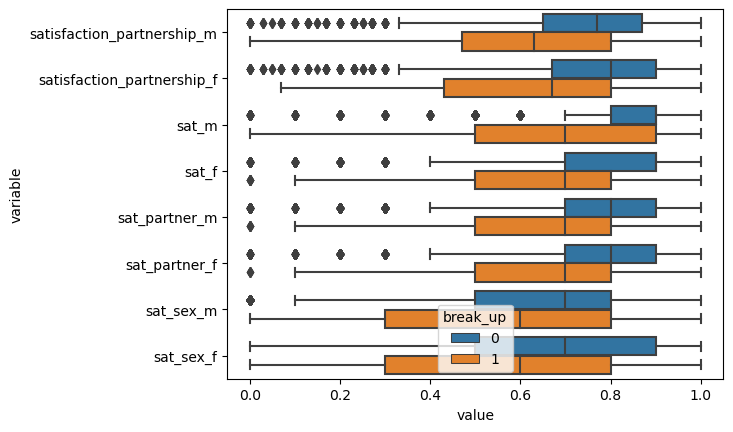

In [962]:
sat_data = agents_sns[[
    "break_up",
    "satisfaction_partnership_m",
    "satisfaction_partnership_f",
    "sat_m", 
    "sat_f", 
    "sat_partner_m",
    "sat_partner_f",
    "sat_sex_m",
    "sat_sex_f",
]].melt(id_vars = "break_up")

sns.boxplot(
    data = sat_data,
    x = "value",
    y = "variable",
    hue = "break_up",
    orient = "h"
)

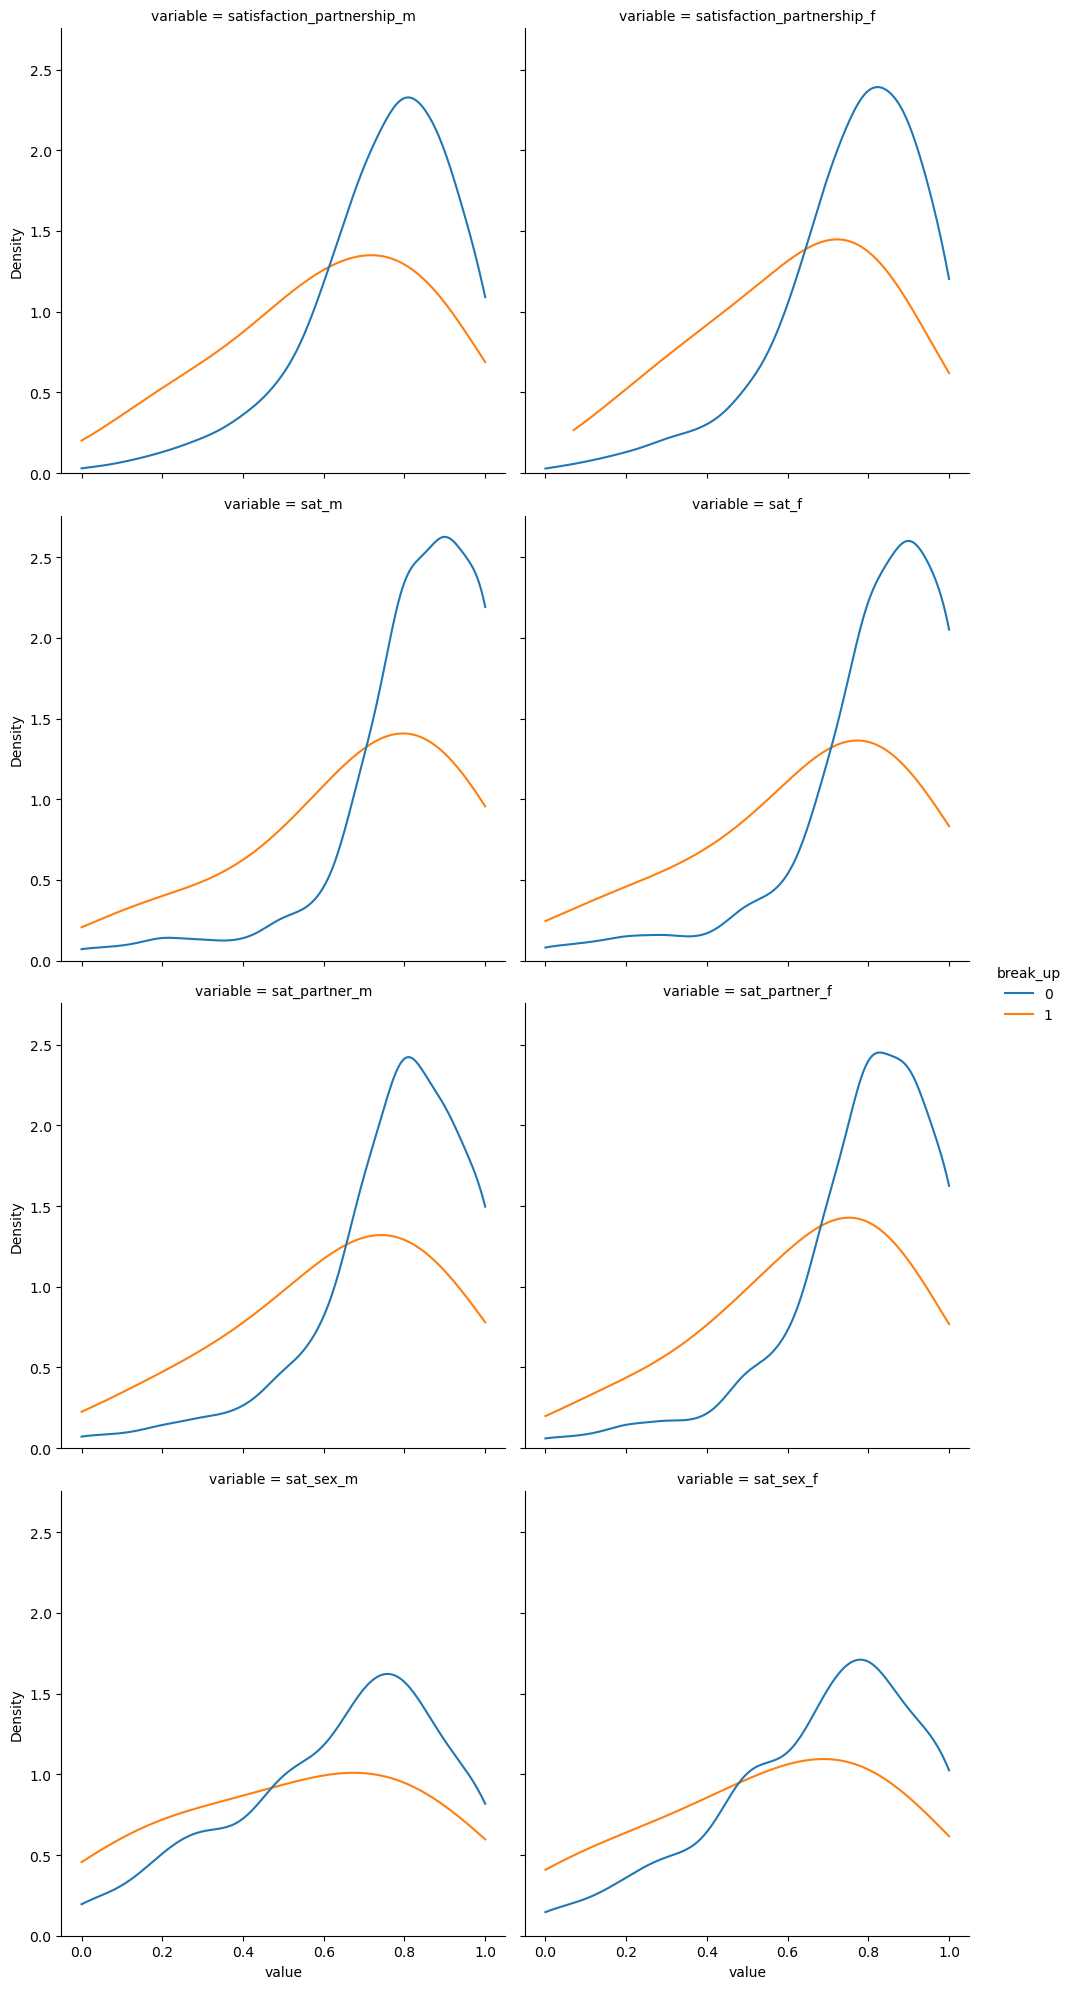

In [963]:
sns.displot(
    data = sat_data,
    x = "value",
    col = "variable",
    col_wrap = 2,
    hue = "break_up",
    kind = "kde",
    common_norm = False,
    bw_adjust = 1.75,
    cut = 0
)

<Axes: xlabel='value', ylabel='variable'>

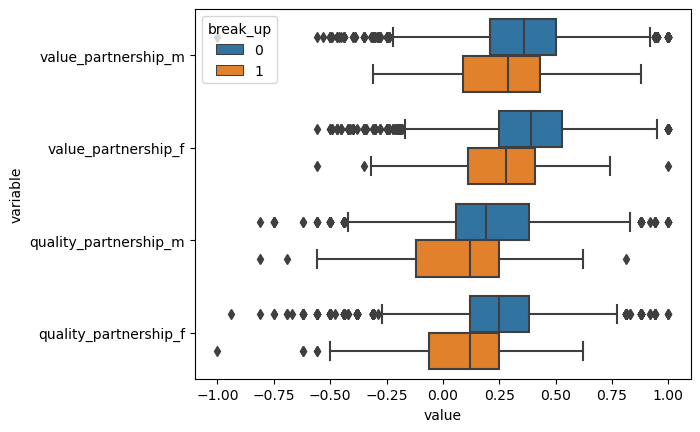

In [964]:
value_data = agents_sns[[
    "break_up",
    "value_partnership_m",
    "value_partnership_f",
    "quality_partnership_m",
    "quality_partnership_f",
]].melt(id_vars = "break_up")

sns.boxplot(
    data = value_data,
    x = "value",
    y = "variable",
    hue = "break_up"
)

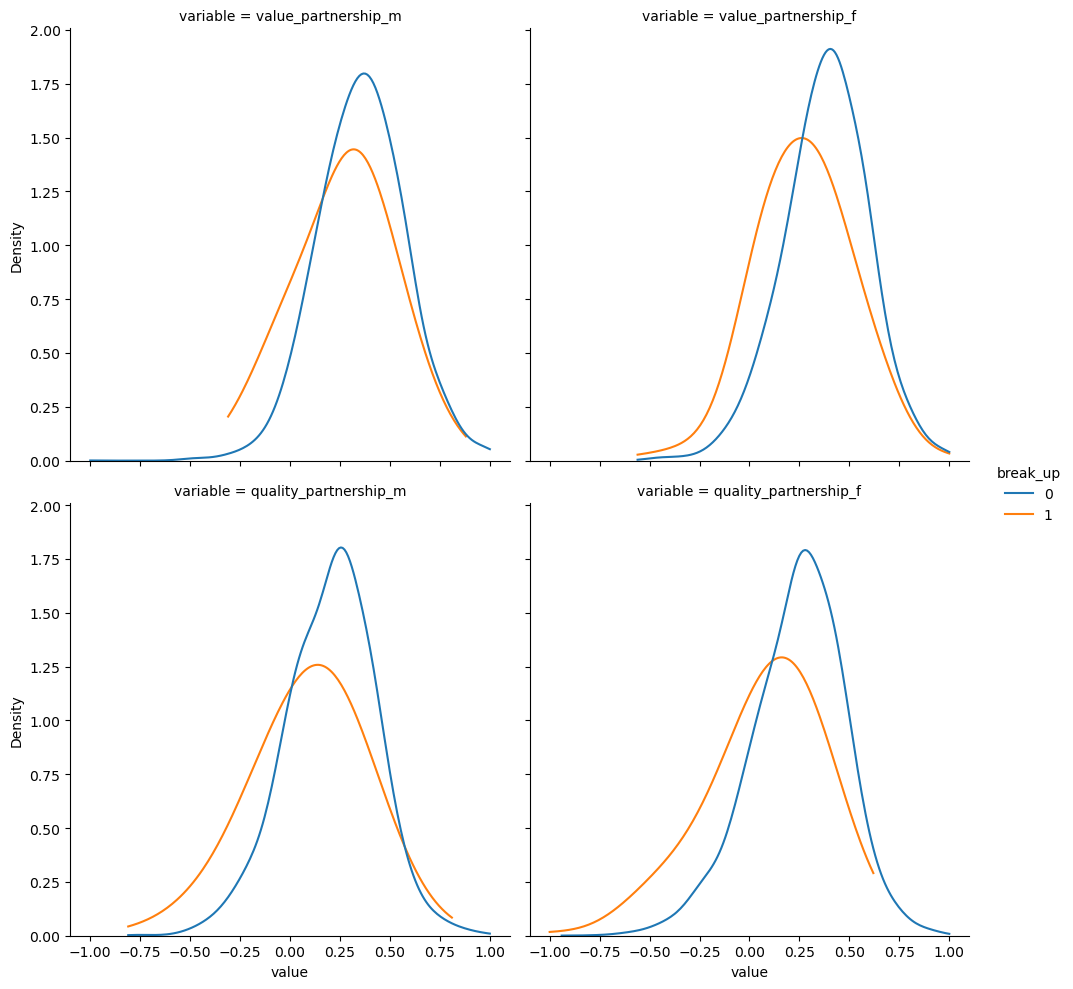

In [965]:
sns.displot(
    data = value_data,
    x = "value",
    col = "variable",
    col_wrap = 2,
    hue = "break_up",
    kind = "kde",
    common_norm = False,
    bw_adjust = 1.75,
    cut = 0
)

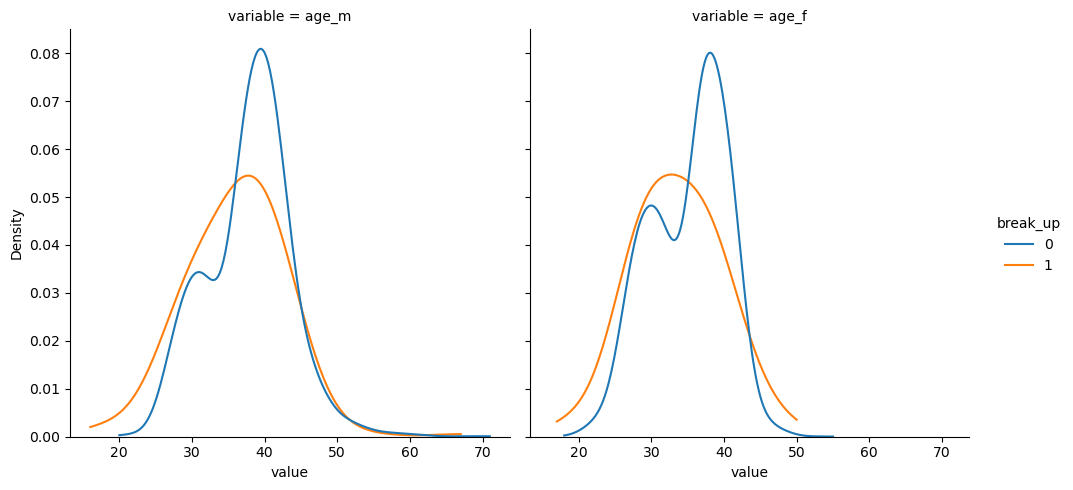

In [966]:
value_data = agents_sns[[
    "break_up",
    "age_m",
    "age_f"
]].melt(id_vars = "break_up")

sns.displot(
    data = value_data,
    x = "value",
    col = "variable",
    col_wrap = 2,
    hue = "break_up",
    kind = "kde",
    common_norm = False,
    bw_adjust = 1.75,
    cut = 0
)

<Axes: xlabel='value', ylabel='variable'>

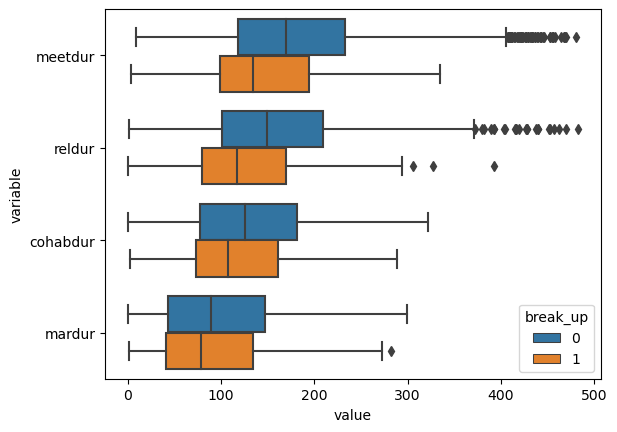

In [934]:
value_data = agents_sns[[
    "break_up",
    "meetdur",
    "reldur",
    "cohabdur",
    "mardur"
]].melt(id_vars = "break_up")

sns.boxplot(
    data = value_data,
    x = "value",
    y = "variable",
    hue = "break_up"
)

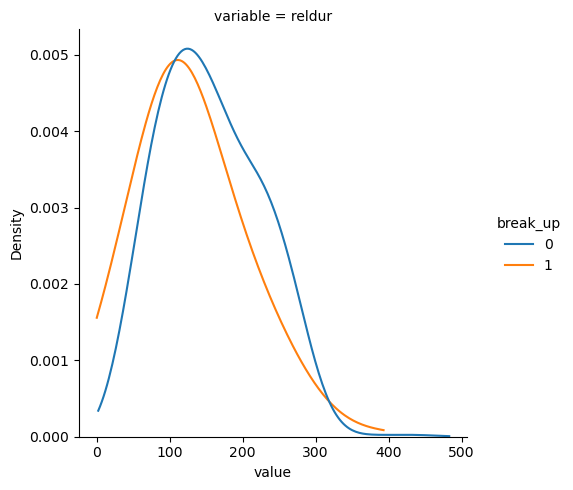

In [968]:

value_data = agents_sns[[
    "break_up",
    "reldur"
]].melt(id_vars = "break_up")

sns.displot(
    data = value_data,
    x = "value",
    col = "variable",
    hue = "break_up",
    kind = "kde",
    common_norm = False,
    bw_adjust = 1.75,
    cut = 0
)

<Axes: xlabel='value', ylabel='variable'>

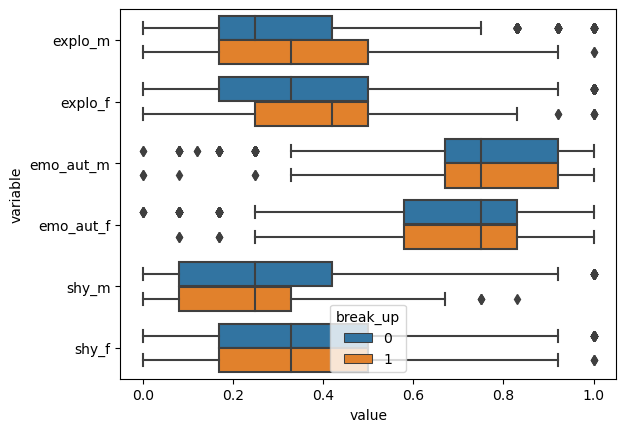

In [936]:
pers_data = agents_sns[[
    "break_up",
    'explo_m',
    'explo_f',
    'emo_aut_m',
    'emo_aut_f',
    'shy_m',
    'shy_f',
]].melt(id_vars = "break_up")

sns.boxplot(
    data = pers_data,
    x = "value",
    y = "variable",
    hue = "break_up"
)

<Axes: xlabel='value', ylabel='variable'>

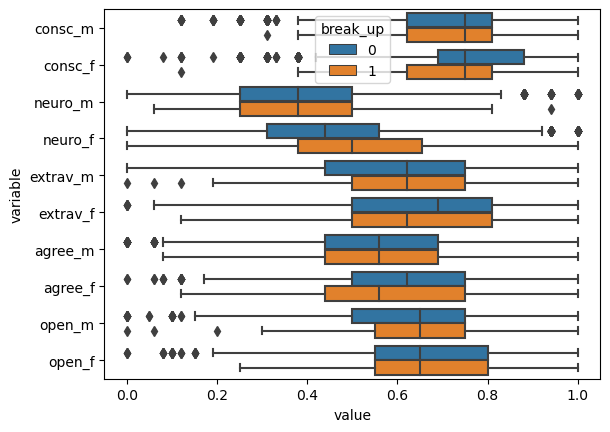

In [937]:
big5_data = agents_sns[[
    "break_up",
    'consc_m',
    'consc_f',
    'neuro_m',
    'neuro_f',
    'extrav_m',
    'extrav_f',
    'agree_m',
    'agree_f',
    'open_m',
    'open_f'
]].melt(id_vars = "break_up")

sns.boxplot(
    data = big5_data,
    x = "value",
    y = "variable",
    hue = "break_up"
)

<Axes: xlabel='value', ylabel='variable'>

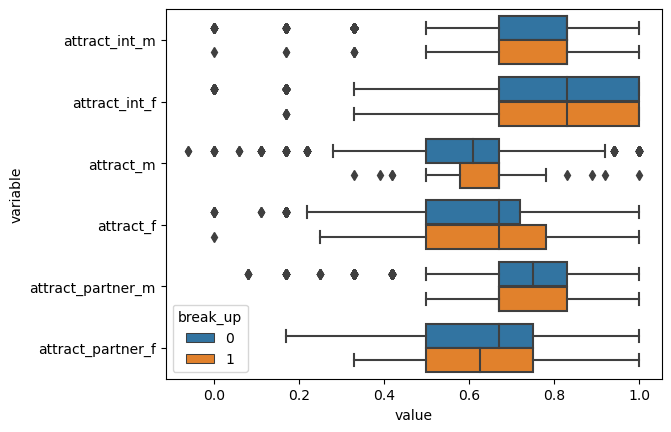

In [947]:
attr_data = agents_sns[[
    "break_up",
    "attract_int_m",
    "attract_int_f",
    "attract_m",
    "attract_f",
    "attract_partner_m",
    "attract_partner_f",
]].melt(id_vars = "break_up")

sns.boxplot(
    data = attr_data,
    x = "value",
    y = "variable",
    hue = "break_up"
)

In [938]:
# Get ID for marriages that end in divorce.
break_up_total = agents_total[["id", "pid", "break_up"]].groupby(["id", "pid"], as_index = False).max()
agents_total = agents_total.merge(break_up_total, how = "left", on = ["id", "pid"], suffixes = (None, "_total"))

# Prepare data for seaborn visualization.
agents_sns = agents_total.copy()
agents_sns["same_partner"] = agents_sns["break_up"].astype("string")

<Axes: xlabel='value', ylabel='variable'>

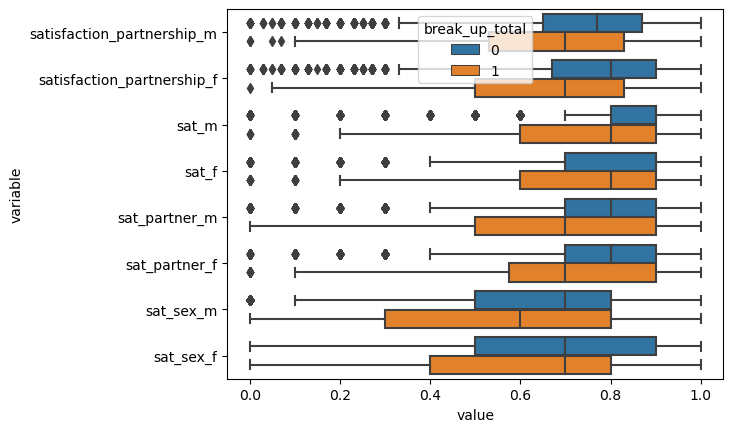

In [939]:
sat_data = agents_sns[[
    "break_up_total",
    "satisfaction_partnership_m",
    "satisfaction_partnership_f",
    "sat_m", 
    "sat_f", 
    "sat_partner_m",
    "sat_partner_f",
    "sat_sex_m",
    "sat_sex_f",
]].melt(id_vars = "break_up_total")

sns.boxplot(
    data = sat_data,
    x = "value",
    y = "variable",
    hue = "break_up_total",
    orient = "h"
)

<Axes: xlabel='value', ylabel='variable'>

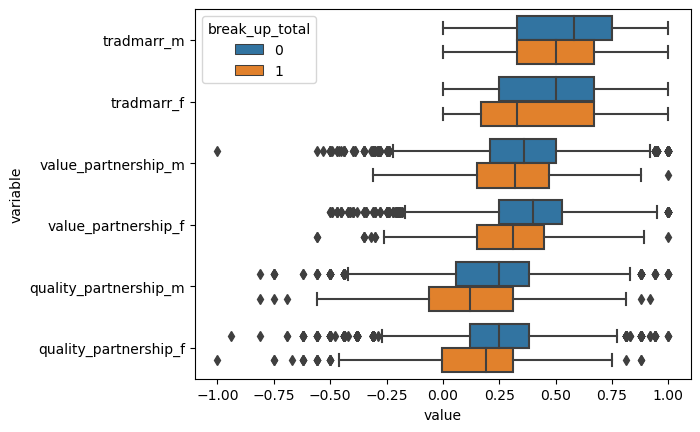

In [940]:
value_data = agents_sns[[
    "break_up_total",
    "tradmarr_m",
    "tradmarr_f",
    "value_partnership_m",
    "value_partnership_f",
    "quality_partnership_m",
    "quality_partnership_f",
]].melt(id_vars = "break_up_total")

sns.boxplot(
    data = value_data,
    x = "value",
    y = "variable",
    hue = "break_up_total"
)

<Axes: xlabel='value', ylabel='variable'>

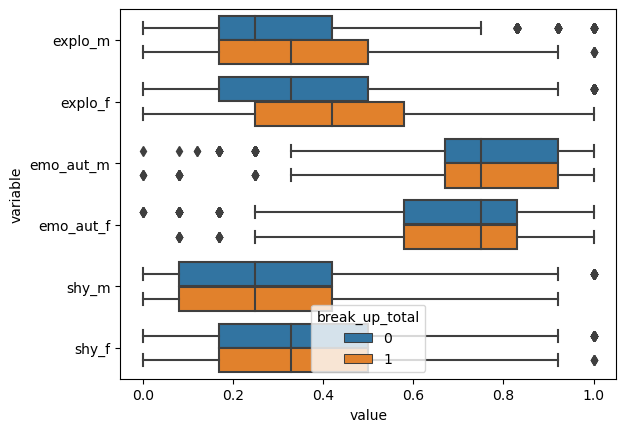

In [941]:
pers_data = agents_sns[[
    "break_up_total",
    'explo_m',
    'explo_f',
    'emo_aut_m',
    'emo_aut_f',
    'shy_m',
    'shy_f',
]].melt(id_vars = "break_up_total")

sns.boxplot(
    data = pers_data,
    x = "value",
    y = "variable",
    hue = "break_up_total"
)

<Axes: xlabel='value', ylabel='variable'>

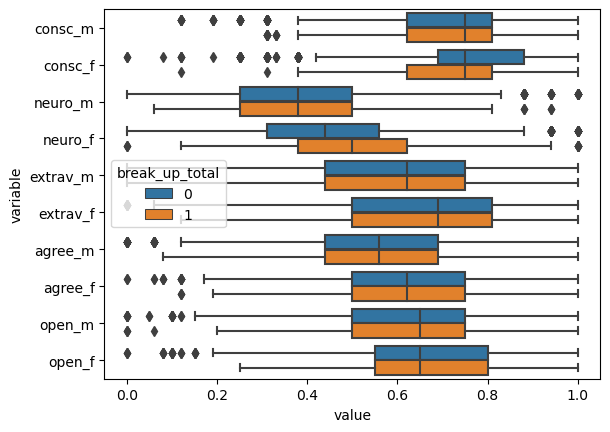

In [942]:
big5_data = agents_sns[[
    "break_up_total",
    'consc_m',
    'consc_f',
    'neuro_m',
    'neuro_f',
    'extrav_m',
    'extrav_f',
    'agree_m',
    'agree_f',
    'open_m',
    'open_f'
]].melt(id_vars = "break_up_total")

sns.boxplot(
    data = big5_data,
    x = "value",
    y = "variable",
    hue = "break_up_total"
)

In [943]:
list(agents_sns.columns)

['id',
 'pid',
 'wave',
 'cohort',
 'sex_gen',
 'psex_gen',
 'age',
 'page',
 'infertile',
 'homosex_new',
 'nkidsbio',
 'yeduc',
 'pyeduc',
 'relstat',
 'marstat',
 'pmarstat',
 'meetdur',
 'reldur',
 'cohabdur',
 'mardur',
 'np',
 'ncoh',
 'nmar',
 'pregnant',
 'tradmarr',
 'value_partnership',
 'quality_partnership',
 'satisfaction_partnership',
 'sat',
 'sat_partner',
 'sat_sex',
 'explo',
 'emo_aut',
 'shy',
 'attract_int',
 'consc',
 'neuro',
 'extrav',
 'agree',
 'open',
 'attract_partner',
 'attract',
 'next_wave',
 'same_partner',
 'np_next',
 'np_diff',
 'break_up',
 'id_p',
 'wave_p',
 'tradmarr_p',
 'value_partnership_p',
 'quality_partnership_p',
 'satisfaction_partnership_p',
 'sat_p',
 'sat_partner_p',
 'sat_sex_p',
 'explo_p',
 'emo_aut_p',
 'shy_p',
 'consc_p',
 'neuro_p',
 'extrav_p',
 'agree_p',
 'open_p',
 'attract_partner_p',
 'attract_p',
 'next_wave_p',
 'same_partner_p',
 'age_m',
 'age_f',
 'yeduc_m',
 'yeduc_f',
 'tradmarr_m',
 'tradmarr_f',
 'value_partnershi

<Axes: xlabel='value', ylabel='variable'>

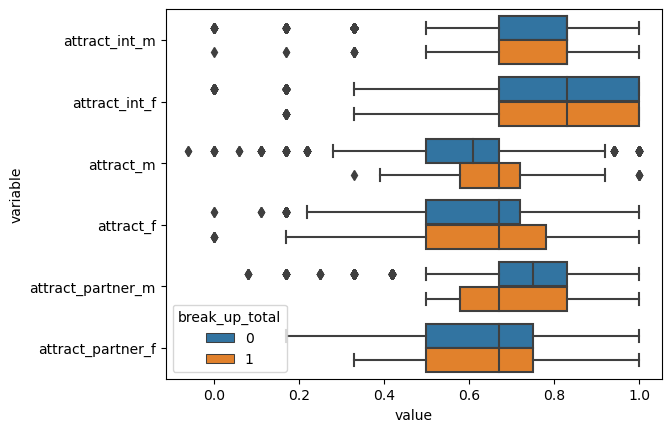

In [946]:
attr_data = agents_sns[[
    "break_up_total",
    "attract_int_m",
    "attract_int_f",
    "attract_m",
    "attract_f",
    "attract_partner_m",
    "attract_partner_f",
]].melt(id_vars = "break_up_total")

sns.boxplot(
    data = attr_data,
    x = "value",
    y = "variable",
    hue = "break_up_total"
)

<Axes: xlabel='attract_m', ylabel='Density'>

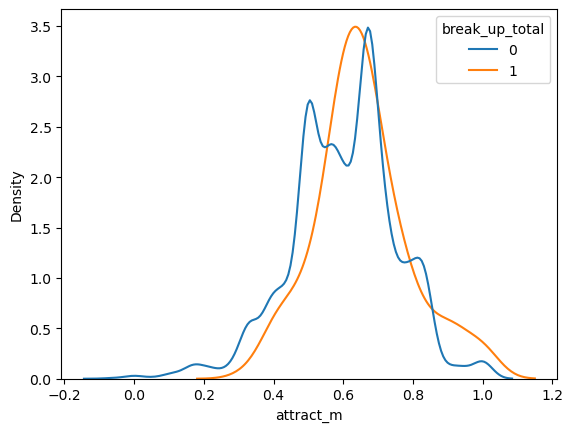

In [951]:
sns.kdeplot(
    data = agents_sns,
    x = "attract_m",
    hue = "break_up_total",
    common_norm = False
)